# Interactive Dynesty Demo

This is a simple interactive demo that briefly goes over nested sampling and some of the features available in `dynesty`.

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
import time, sys, os
from collections import OrderedDict

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


## Overview

In standard Bayesian inference, we are interested in estimating the **posterior** $P(\boldsymbol{\Theta} | \mathbf{D}, M)$ of a set of **parameters** $\boldsymbol{\Theta}$ for a given **model** $M$ given some **data** $\mathbf{D}$. This can be factored into a form known as **Bayes' Rule** to give

$$ P(\boldsymbol{\Theta} | \mathbf{D}, M) = \frac{P(\mathbf{D} | \boldsymbol{\Theta}, M) P(\boldsymbol{\Theta} | M)}{P(\mathbf{D} | M)}$$

where $P(\mathbf{D} | \boldsymbol{\Theta}, M) \equiv \mathcal{L}(\boldsymbol{\Theta})$ is the **likelihood**, $P(\boldsymbol{\Theta}| M) \equiv \pi(\boldsymbol{\Theta})$ is the **prior**, and 

$$ P(\mathbf{D} | M) \equiv \mathcal{Z} = \int_{\Omega_{\boldsymbol{\Theta}}} \mathcal{L}(\boldsymbol{\Theta}) \pi(\boldsymbol{\Theta}) \, d\boldsymbol{\Theta} $$

is the **evidence**, where the integral is taken over the entire domain $\Omega_{\boldsymbol{\Theta}}$ of $\boldsymbol{\Theta}$ (i.e. over all possible $\boldsymbol{\Theta}$).

**Nested sampling** [(Skilling 2006)](https://projecteuclid.org/euclid.ba/1340370944) attempts to estimate $\mathcal{Z}$ by treating the integral of the posterior over all $\boldsymbol{\Theta}$ as instead an integral over the **prior volume** $X(\lambda)$ contained within an **iso-likelihood contour** set by $\mathcal{L}(\boldsymbol{\Theta}) = \lambda$. 

More formally, defining the prior volume as

$$ X(\lambda) \equiv \int_{\boldsymbol{\Theta} : \mathcal{L}(\boldsymbol{\Theta}) > \lambda} \pi(\boldsymbol{\Theta}) \, d\boldsymbol{\Theta} $$

the evidence is just

$$ \mathcal{Z} = \int_{0}^{+\infty} X(\lambda) \, d\lambda = \int_{0}^{1} \mathcal{L}(X) \, dX $$

assuming $\mathcal{L}(X(\lambda)) = \lambda$ exists. In other words, if we could evaluate the iso-likelihood contour $\mathcal{L}_i \equiv \mathcal{L}(X_i)$ associated with a bunch of samples from the prior volume $1 > X_0 > X_1 > \dots > X_i > \dots > X_N > 0$, we can compute the evidence using standard numerical integration techniques (e.g., the trapezoid rule). Computing the evidence using these "nested shells" is what gives nested sampling its name.

## How Nested Sampling Works

### Basic Algorithm

We start with a number of $K$ **"live" points** drawn from the prior $\pi(\boldsymbol{\Theta})$. At each iteration $i$, we remove the live point with the lowest likelihood $\mathcal{L}_i$ and replace it with a new live point sampled from the prior subject to the constraint $\mathcal{L}_{i+1} \geq \mathcal{L}_i$. 

### Evidence Estimation

It can be shown through some neat statistical arguments (which are outlined in more detail below) that this sampling procedure actually allows us to approximate the prior volume of the previous live point (a **"dead" point**) based on the current iteration as

$$ \ln X_i \approx -\left(i \pm \sqrt{i}\right)/K \quad .$$

This enables us to directly estimate the evidence using a set of $N$ dead points via

$$ \mathcal{Z} = \int_{0}^{1} \mathcal{L}(X) \, dX \approx \hat{\mathcal{Z}} = \sum_{i=1}^{N} \mathcal{L}_i w_i $$

where $w_i = \Delta X_i$ is the associated weight. For a simple quadratic integration scheme, for instance, we can take $w_i = \frac{1}{2} (X_{i-1} - X_{i+1})$.

### Posterior Estimation

We can subsequently estimate posteriors "for free" from the same $N$ dead points by assigning each sample its associated **importance weight**

$$ P(\boldsymbol{\Theta}_i) \equiv p_i \approx \hat{p}_i = \frac{\mathcal{L}_i w_i}{\sum_{i=1}^{N} \mathcal{L}_i w_i} = \frac{\mathcal{L}_i w_i}{\hat{\mathcal{Z}}} \propto \mathcal{L}_i w_i \quad . $$

### Stopping Criteria

The remaining prior volume $\Delta \mathcal{Z}_i$ can roughly be bounded by the maximum likelihood point contained within the live set $\mathcal{L}_{\max}$ multipled by the expected remaining prior volume $X_i$,

$$ \Delta \mathcal{Z}_i \approx \mathcal{L}_{\max} X_i \quad . $$

This essentially assumes that the remaining prior volume interior to the last dead point is a uniform slab with likelihood $\mathcal{L}_{\max}$. In general, this error estimate often serves as a reasonable threshold that can be used for deciding when to stop sampling from an arbitrary distribution. Other stopping criteria are discussed later.

### Challenges

The main theoretical requirement for nested sampling are:
1. that samples are drawn sequentially subject to the hard likelihood constraint $\mathcal{L}_{i+1} \geq \mathcal{L}_{i}$, and
2. that all samples used to compute/replace live points are **independent and identically distributed (i.i.d.)** random variables drawn from the prior.

The first requirement is entirely algorithmic and easy to satisfy. The second, however, is much more difficult to satisfy while efficiently generating samples. While it is straightforward in theory to generate samples from the prior, by design nested sampling makes this type of simple sample generation increasingly more inefficient as time goes on. 

Solutions to this problem involve some combination of:
- proposing new live points by evolving one or more current live points to new (independent) positions within the likelihood constraint and
- approximately bounding the iso-likelihood contours so avoid sampling from regions associated with larger prior volumes.

In both cases, it is much easier to deal with uniform priors. As a result, most nested sampling algorithms/packages (including `dynesty`) sample first over the unit cube and before transforming samples back to the original parameter space. Accomplishing this requires an appropriate **prior transform** (i.e. the inverse CDF).

## Simple Demonstration: Gaussian Shells

Let's give `dynesty` a test run over a set of 3-D Gaussian shells.

In [2]:
import dynesty

In [3]:
# Gaussian shells likelihood

# circle/shell function
def logcirc(theta, c):
    d = sqrt(sum((theta - c)**2, axis=-1))  # |theta - c|
    return const - (d - r)**2 / (2. * w**2) # log-circ

# log-likelihood function
def loglike(theta, c1, c2):
    return logaddexp(logcirc(theta, c1), logcirc(theta, c2))

# parameters
r = 2. # radius of the shells
w = 0.1 # widths of the shells
const = log(1. / sqrt(2. * pi * w**2)) # normalizing constant
c1 = np.array([-3.5, 0., 0.]) # location of shell 1
c2 = np.array([3.5, 0., 0.]) # location of shell 2

As described above, `dynesty` samples over the unit cube. We now define the transformation that takes our uniform samples and transforms them back to the variables of interest.

In [4]:
# prior transform
def prior_transform(x):
    """Defines a flat prior between -6 and 6 in all dimensions."""
    return 12. * x - 6.

With that all set up, we can now initialize our sampler. The specific `NestedSampler` returned by `dynesty` depends on the specified bounding method. `dynesty` supports a number of methods both for bounding the target distribution:
- **no bound** (`'none'`),
- a **single bounding ellipsoid** (`'single'`),
- **multiple bounding ellipsoids** (`'multi'`),
- **overlapping balls** around all live points (`'balls'`), and
- **overlapping cubes** around all live points (`'cubes'`).

Conditioned on those bounds, `dynesty` supports several different sampling methods:
- **uniform** sampling (`'unif'`),
- **random walks** away from a current live point (`'rwalk'`),
- **slice sampling** away from a current live point (`'slice'`), and
- **random trajectories** (also known as *reflective slice sampling* or *Galilean Monte Carlo*) away from a current live point (`'rtraj'`).

Here we'll use multi-ellipsoidal decomposition [(Feroz et al. 2008)](https://arxiv.org/abs/1306.2144) to bound the likelihood distribution as we go using $K=100$ live points, and propose new live points by sampling uniformly within the set of (overlapping) ellipsoids. These tend to give very efficient proposals in low-to-moderate dimensions ([Handley et al. 2015](https://arxiv.org/abs/1506.00171)), although they have a tendency to over-constrain the remaining prior volume ([Buchner 2014](https://arxiv.org/abs/1407.5459)). By default, `dynesty` uses bootstrapping to mitigate this problem, which works well in general but can significantly slow down new proposal generation when many ellipsoids are used.

In [5]:
# initialize our nested sampler
f = lambda theta: loglike(theta, c1, c2)
sampler = dynesty.NestedSampler(f, prior_transform, ndim=3, bound='multi', sample='unif', nlive=1000)

### Sampling Internally

We can now begin sampling from our target distribution. Sampling will continue until the specified stopping criteria are reached, which can either be a fixed number of iterations (`maxiter`), a fixed number of likelihood calls (`maxcall`), or specified $\ln \Delta \mathcal{Z}_i$ (`dlogz`) tolerance. By default `dynesty` uses $\ln \Delta \mathcal{Z}_i < \ln(K+1)$ if we want to "recycle" the final remaining set of live points that would otherwise be wasted (this is the default behavior). Otherwise, $\ln \Delta \mathcal{Z}_i < 0.5$ is used.

In [6]:
# sample from the target distribution
sampler.run_nested()

# save our results and print a summary
res = sampler.results
print res.summary()

iter: 3252+1000 | nc: 1 | ncall: 8999 | eff(%): 46.449 | logz: -2.744 +/-  0.060


nlive: 1000
niter: 3251
ncall: 7999
eff(%): 46.449
logz: -2.744 +/-  0.060


That looks pretty good overall. In particular, our sampling efficiency over the course of our ~5.5k samples is ~50%, significantly higher than other sampling methods such as **Markov Chain Monte Carlo**, especially given that our samples are (in theory) i.i.d. We'll return to this comparison in more detail later.

Also note that our estimated error is significantly smaller than our original upper bound we used to determine our stopping criterion. This is both due to `dynesty`'s re-use of the remaining live points, which allows us to probe the prior volume interior to our (original) final dead point, and the fact that our upper bound is often relatively conservative.

### Adding Samples and Sampling Externally

Let's see if we can do any better by adding more samples until an even more stringent stopping criterion is met. By default, `dynesty` keeps track of the live points and final set of samples, making it easy to add additional samples to the same run.

In addition to having our samples generated entirely internally to our `NestedSampler` object via `run_nestle()`, `dynesty` can also be run explicitly as a **generator** using the `sample()` option. We demonstrate this feature below.

In [22]:
# manually disabling bootstrapping to speed up final computation
# in general, do NOT modify sampler internals unless you really know what you're doing
sampler.bootstrap = 0  # number of bootstrap resampling steps to expand proposal distribution
sampler.enlarge = 1.25  # volume expansion factor

# continue sampling from where we left off
for it, results in enumerate(sampler.sample(dlogz=0.05)):
    (worst, ustar, vstar, loglstar, logvol, logwt, logz, logzerr, h, nc) = results
    sys.stderr.write("\riter+: {:d} | nc: {:d} | "
                     "logz: {:6.3f} +/- {:6.3f}".format(it, nc, logz, logzerr))

# add the remaining live points back into our final results
for it2, results in enumerate(sampler.add_live_points()):
    (worst, ustar, vstar, loglstar, logvol, logwt, logz, logzerr, h, nc) = results
    sys.stderr.write("\riter+: {:d}+{:d} | nc: {:d} | "
                     "logz: {:6.3f} +/- {:6.3f}".format(it, it2+1, nc, logz, logzerr))

sys.stderr.flush()

res2 = sampler.results
print res2.summary()

iter+: 668+1000 | nc: 1 | logz: -2.723 +/-  0.060

nlive: 1000
niter: 7127
ncall: 27745
eff(%): 26.648
logz: -2.723 +/-  0.060


Those results are nearly identical even though we doubled the number of samples. This demonstrates how much we can gain by recycling the final set of live points.

Let's see how we did!

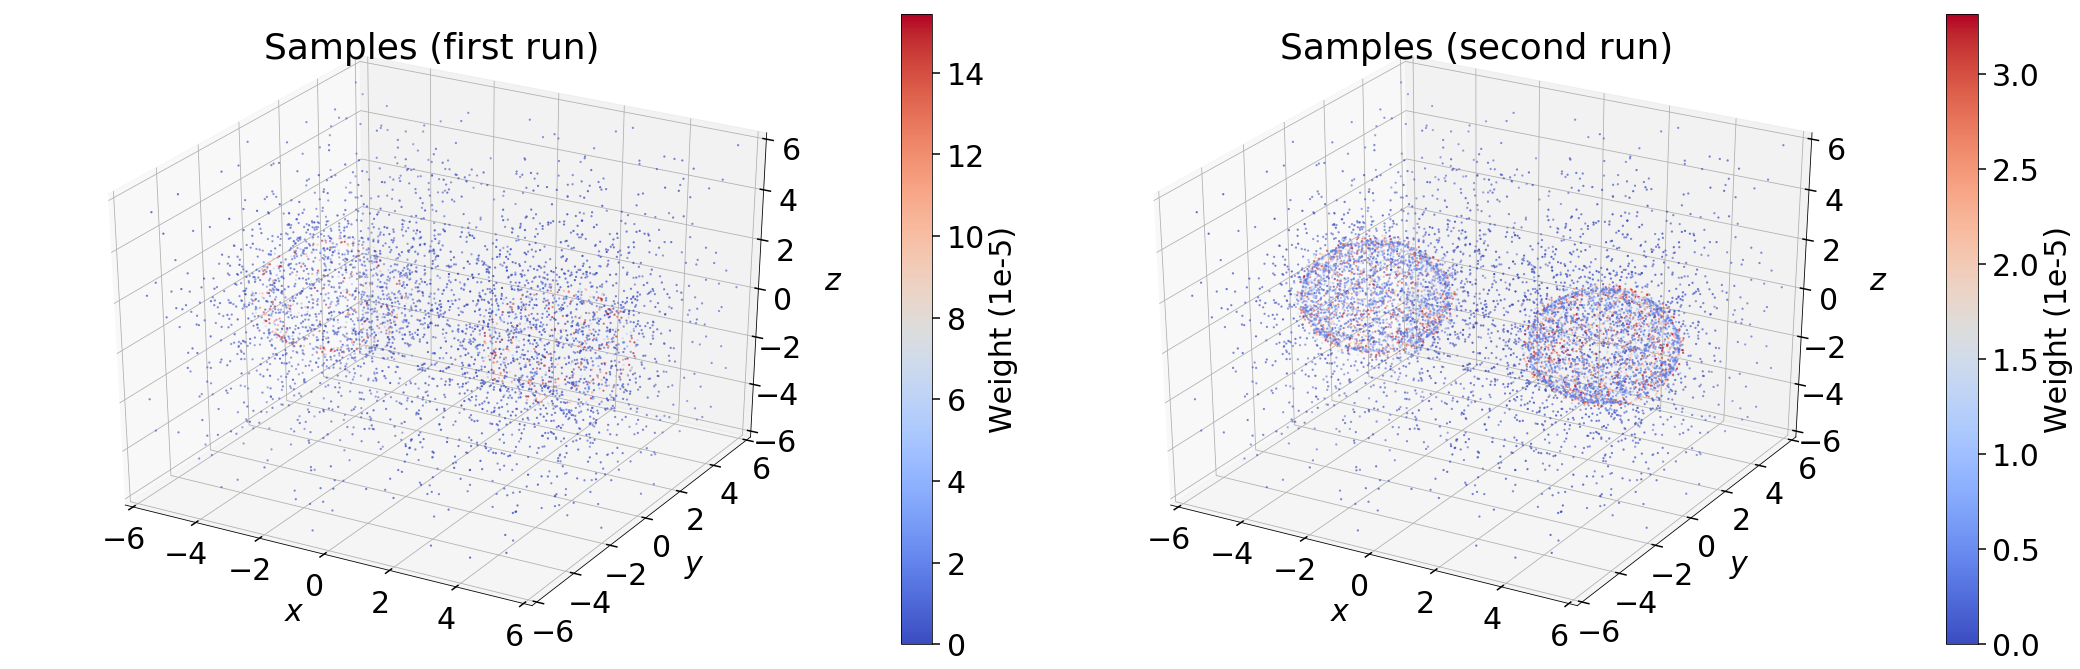

In [23]:
# 3-D plot of position and likelihood, colored by weight
fig = figure(figsize=(30, 10))
ax = fig.add_subplot(121, projection='3d')
p = ax.scatter(res.samples[:, 0], res.samples[:, 1], res.samples[:, 2],
               marker='.', c=exp(res.logwt) * 1e5, linewidths=(0.,), cmap='coolwarm')
ax.set_xlim(-6., 6.)
ax.set_xlabel(r'$x$', labelpad=25)
ax.set_ylim(-6., 6.)
ax.set_ylabel(r'$y$', labelpad=25)
ax.set_zlim(-6., 6.)
ax.set_zlabel(r'$z$', labelpad=25)
ax.set_title('Samples (first run)')
fig.colorbar(p, label='Weight (1e-5)')
tight_layout()
ax = fig.add_subplot(122, projection='3d')
p = ax.scatter(res2.samples[:, 0], res2.samples[:, 1], res2.samples[:, 2],
               marker='.', c=exp(res2.logwt) * 1e5, linewidths=(0.,), cmap='coolwarm')
ax.set_xlim(-6., 6.)
ax.set_xlabel(r'$x$', labelpad=25)
ax.set_ylim(-6., 6.)
ax.set_ylabel(r'$y$', labelpad=25)
ax.set_zlim(-6., 6.)
ax.set_zlabel(r'$z$', labelpad=25)
ax.set_title('Samples (second run)')
fig.colorbar(p, label='Weight (1e-5)')
tight_layout()

That looks pretty good overall. We see that the majority of the importance weight $\hat{p}_i$ is concentrated around the middle of the shells, a compromise between the likelihood $\mathcal{L}_i$ and the change in prior volume $w_i = \Delta X_i$.

## Visualizing Our Results

Let's take a more detailed look at what our nested sampler is doing over the course of our run. `dynesty` has several built-in plotting utilities to help visualize outputs within the `dynesty.plotting` module. We'll import that now.

In [12]:
from dynesty import plotting as dyplot

### Prior Volume Compression

One of the most direct ways of visualizing how nested sampling computes the evidence is by examining the relationship between the prior volume $\ln X_i$ and:
1. the (effective) iteration $i$, which illustrates how quickly/slowly our samples are compressing the prior volume,
2. likelihood $\mathcal{L}_i$, to see how we quickly/slowly we sample "up" the likelihood curve
3. importance weight $\hat{p}_i$, showcasing where the bulk of the **posterior mass** is located, and 
4. evidence $\hat{\mathcal{Z}}_i$, to see where most of the evidence is coming from.

This can be done using the `runplot(results)`.

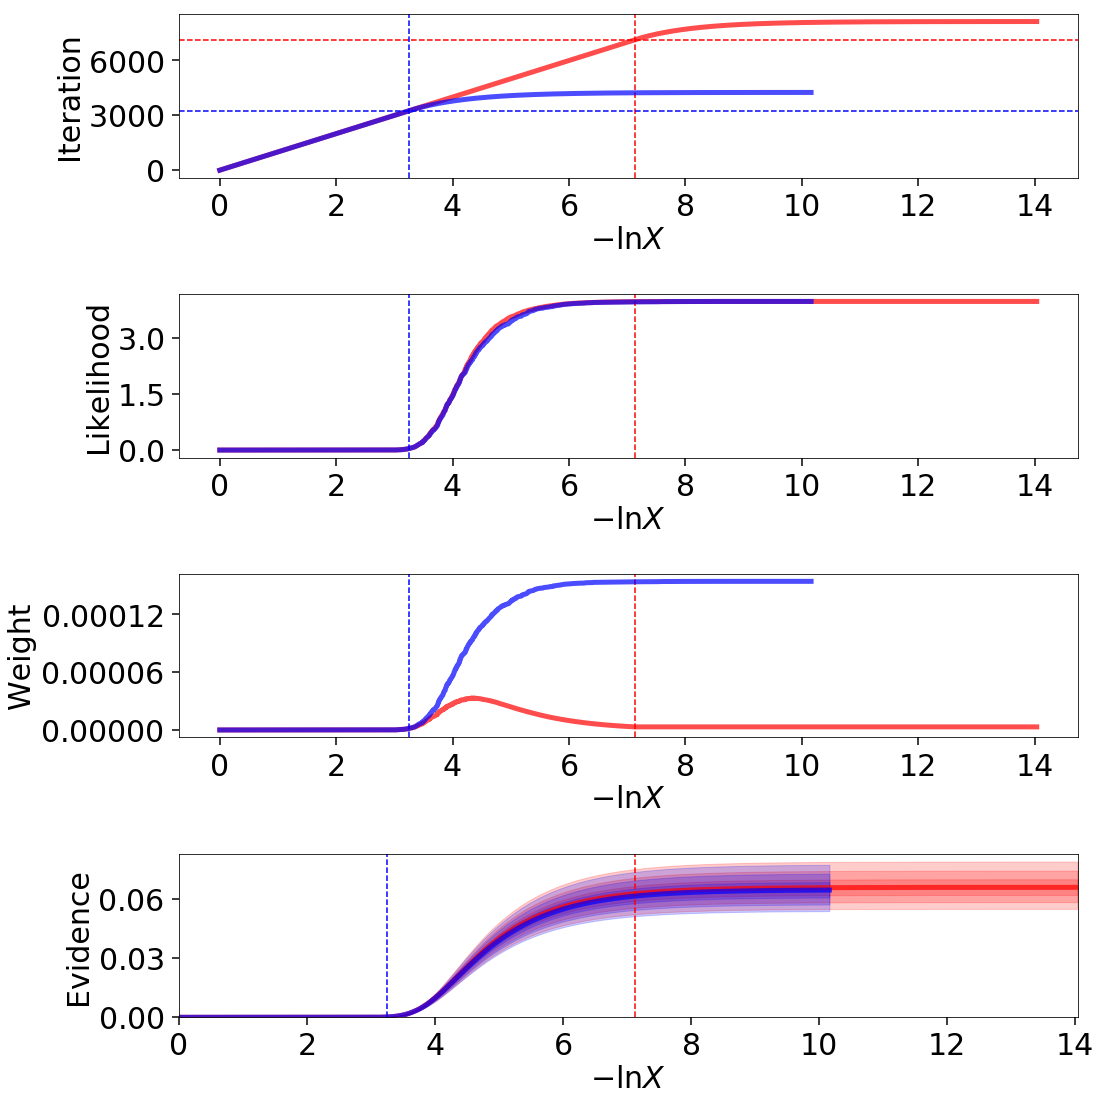

In [24]:
# plot extended run
fig, axes = dyplot.runplot(res2, color='red')

# overplot original run
fig, axes = dyplot.runplot(res, color='blue', lnz_truth=exp(-1.75), truth_color='black', fig=(fig, axes))
tight_layout()

We see that up until we recycle our final set of live points (indicated by the dashed lines), the relationship between $\ln X_i$ and $i$ is linear, as we'd expect. Afterwards, however, it becomes somewhat logarithmic. This is because the remaining $K$ live points are uniformly sampled interior to $X_N$ (the final prior volume enclosed by our last dead point), with the $k$th smallest likelihood of the set encompassing (on average) a prior volume of $\ln X_{(k)} \approx \ln(X_N) - \ln(K+1) + \ln(K+1-k)$. This leads to even more rapid compression of the prior volume. While this introduces additional sampling noise, visible in $\mathcal{L}_i$ and $\hat{p}_i$, the overall effect on the evidence is quite muted (especially given the estimated uncertainties).

### Traces and Posteriors

A standard way for visualizing how our sampler is doing is by taking a look at the **traces** of individual  particles (i.e. "dead points") to see what path they are taking through the distribution as well as the 1-D **marginalized posteriors** to see how well constrained our results ultimately are (especially given the heavily skewed set of weights often provided by nested sampling, as shown above). 

This can be done using `traceplot(results)`. By default, it returns the samples color-coded by their relative weight and the 1-D marginalized posteriors smoothed by a Gaussian kernel by ~2% of the provided range (default 5-sigma).

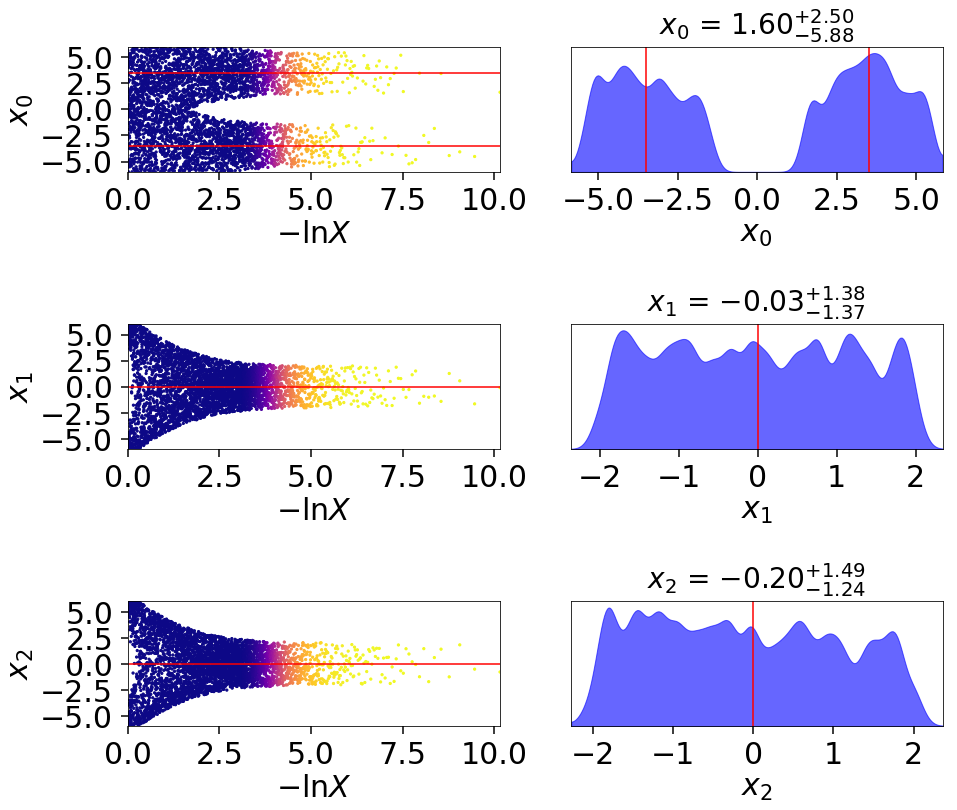

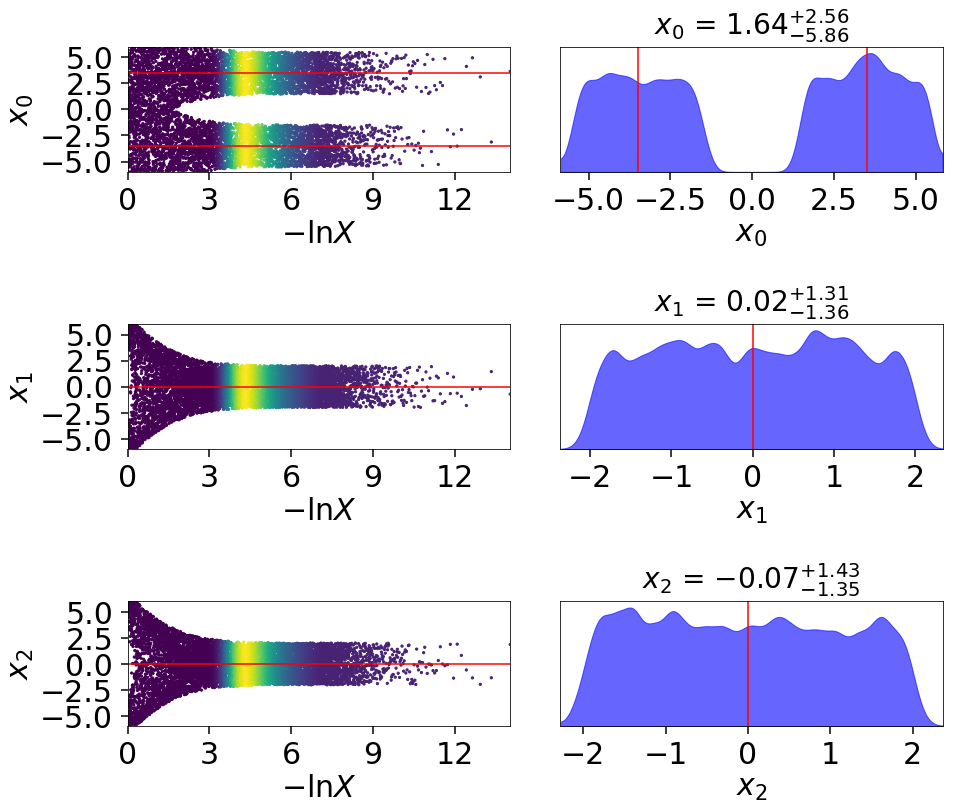

In [27]:
# plotting the original run
fig, axes = dyplot.traceplot(res, truths=[[-3.5, 3.5], 0., 0.], show_titles=True, trace_cmap='plasma',
                             title_kwargs={'fontsize': 28, 'y': 1.05}, quantiles=None,
                             fig=subplots(3, 2, figsize=(14, 12)))
tight_layout()

# plotting the continued run
fig, axes = dyplot.traceplot(res2, truths=[[-3.5, 3.5], 0., 0.], show_titles=True, trace_cmap='viridis',
                             title_kwargs={'fontsize': 28, 'y': 1.05}, quantiles=None,
                             fig=subplots(3, 2, figsize=(14, 12)))
tight_layout()

We see that although the evidence we estimate is almost identical, the posteriors we derive in our continued run improve considerably since we have more finely sampled the bulk of the posterior mass.

### Corner Plots

In addition to trace plots, one other common way to visualize your results is using **corner plots** (also called triangle plots), which show a combination of 1 and 2-D marginalized posteriors. `dynesty` supports corner plots via `cornerpoints()`, which plots the individual projected samples, and `cornerplot()`, which plots the 1-D and 2-D marginal posteriors. (Note that both functions are based on the excellent `corner` [package](http://corner.readthedocs.io/en/latest/) by Daniel Foreman-Mackey.)

Let's first take a look at the positions and weights of our individual samples.

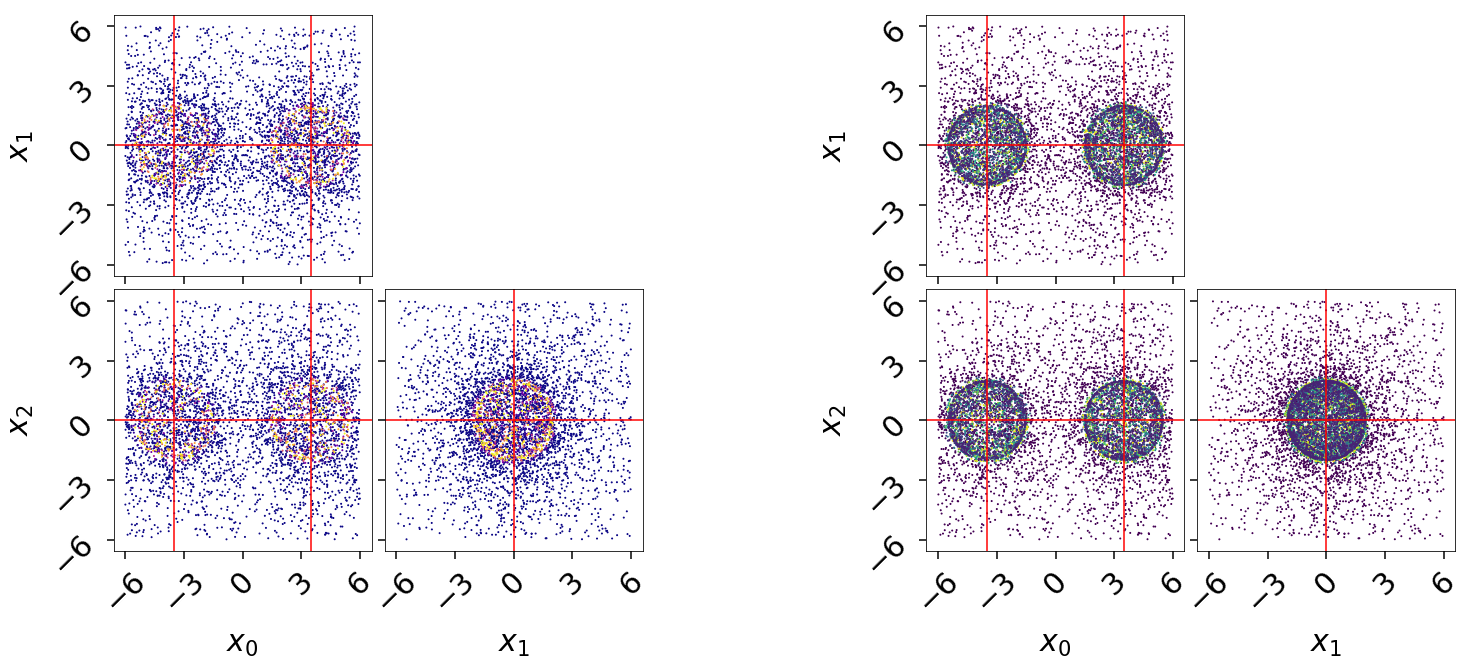

In [62]:
# initialize figure
fig, axes = subplots(2, 5, figsize=(25, 10))
axes = axes.reshape((2, 5))
[a.set_frame_on(False) for a in axes[:, 2]]
[a.set_xticks([]) for a in axes[:, 2]]
[a.set_yticks([]) for a in axes[:, 2]]

# plot initial run (left)
fg, ax = dyplot.cornerpoints(res, cmap='plasma', truths=[[-3.5, 3.5], 0., 0.],
                             fig=(fig, axes[:, :2]))

# plot extended run (right)
fg, ax = dyplot.cornerpoints(res2, cmap='viridis', truths=[[-3.5, 3.5], 0., 0.],
                             fig=(fig, axes[:, 3:]))

Just by looking at our projected samples, it is readily apparent that our extended run does a much better job of localizing the overall distribution. Let's try and get a better qualatative handle on this below using `cornerplot`. By default, the 1-D and 2-D marginal posteriors are smoothed by 2% in the specified range using a
Gaussian (Normal) kernel.

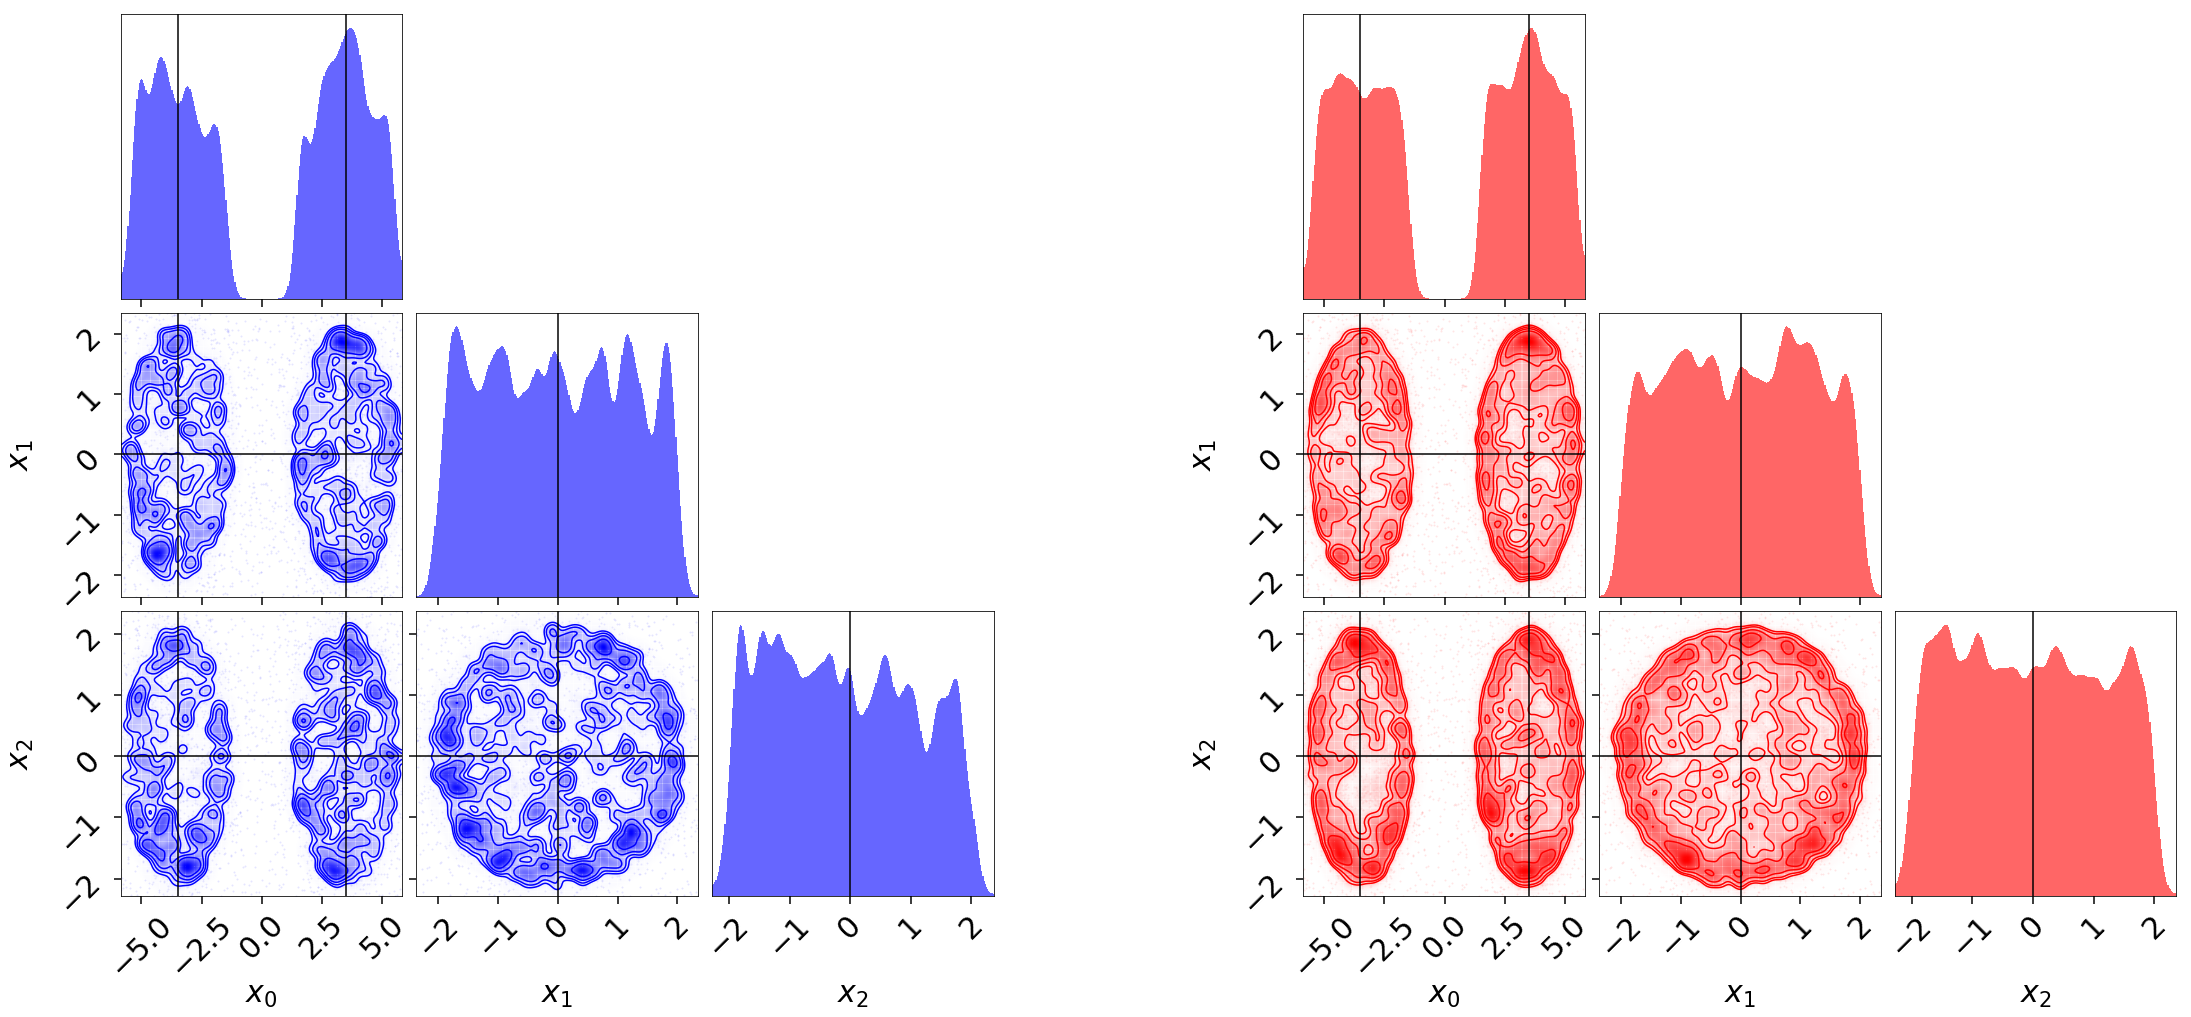

In [63]:
# initialize figure
fig, axes = subplots(3, 7, figsize=(35, 15))
axes = axes.reshape((3, 7))
[a.set_frame_on(False) for a in axes[:, 3]]
[a.set_xticks([]) for a in axes[:, 3]]
[a.set_yticks([]) for a in axes[:, 3]]

# plot initial run (left)
fg, ax = dyplot.cornerplot(res, color='blue', truths=[[-3.5, 3.5], 0., 0.], truth_color='black',
                           quantiles=None, fig=(fig, axes[:, :3]))

# plot extended run (right)
fg, ax = dyplot.cornerplot(res2, color='red', truths=[[-3.5, 3.5], 0., 0.], truth_color='black',
                           quantiles=None, fig=(fig, axes[:, 4:]))

Our original distribution appears to give significantly "noisier" estimates of the posterior than our extended run, although both don't appear as "smooth" as many distributions samples with MCMC. Again, we'll quantify this more later.

### Proposals

To visualize how we're "walking up" these shells in likelihood, we can look at the evolution of our proposal in a given 2-D projection over the course of the run using `proposal()`. The function allows us to look at two proposal distributions from two different perspectives: the proposal distribution used to propose new live points at a specific iteration (specified using `it`), or the proposal distribution a given dead point originated from (specified using `idx`). While `proposal()` natively plots in the space of the unit cube, if a specified prior transform function is passed all samples are instead converted to the original (native) model space.

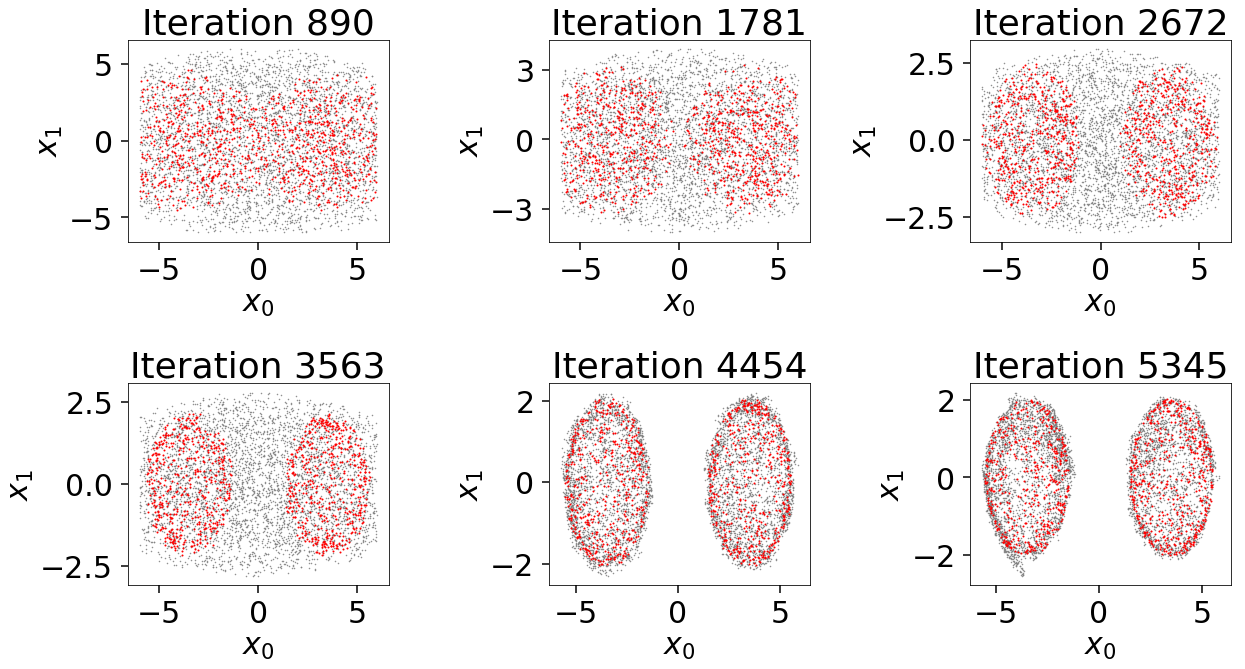

In [74]:
# initialize figure
fig, axes = subplots(2, 3, figsize=(18, 10))

# plot 6 snapshots over the course of the run
for i, a in enumerate(axes.flatten()):
    it = int((i+1)*res2.niter/8.)
    # overplot the result onto each subplot
    temp = dyplot.proposal(res2, dims=(0, 1), it=it, prior_transform=prior_transform, max_n_ticks=3,
                           show_live=True, fig=(fig, a))
    a.set_title('Iteration {0}'.format(it))
tight_layout()

Alternately, `cornerprop` generates `cornerpoints`-style plot for our proposals.

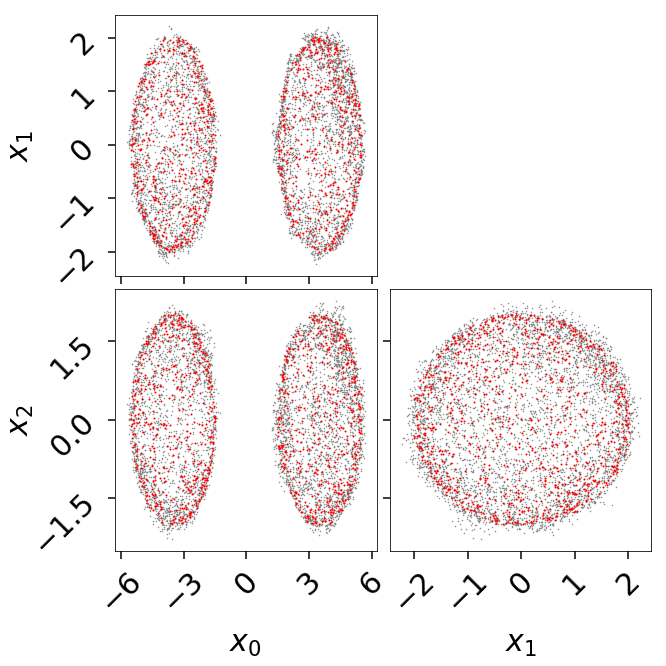

In [77]:
# initialize figure
fig, axes = subplots(2, 2, figsize=(10, 10))

# plot proposals in corner format
fg, ax = dyplot.cornerprop(res2, it=5000, prior_transform=prior_transform, show_live=True, fig=(fig, axes))

We see that our multi-ellipsoid proposal is able to adapt well to the shells over time, ensuring we continue to make efficient proposals without violating our uniform sampling assumptions.

### THE REMAINDER OF THE NOTEBOOK IS OUT OF DATE.

## Dimensional Scaling

Let's see how our performance scales with dimensionality here.

In [11]:
nlive = 1000

# ndim Gaussian shells
def run(ndim):
    """Convenience function for running in any dimension"""

    c1 = zeros(ndim)
    c1[0] = -3.5
    c2 = zeros(ndim)
    c2[0] = 3.5
    f = lambda theta: loglike(theta, c1, c2)
    sys.stdout.write("Ndim={0}...".format(ndim))
    sys.stdout.flush()
    sampler = dynesty.NestedSampler(f, prior_transform, ndim, bound='multi', sample='uniform', nlive=nlive,
                                    **{'bootstrap': 0})
    sampler.run_nested()
    sys.stderr.flush()
    return sampler.results

In [12]:
dims = array([2, 5, 10, 20]) # dimensions to sample

# analytic log-evidence values
analytic_logz = {2: -1.75,
                 5: -5.67,
                 10: -14.59,
                 20: -36.09} 
                 #30: -60.13}
                 #50: -112.42}

# compute results
results = OrderedDict()
for ndim in dims:
    t0 = time.time()
    results[ndim] = run(ndim)
    results[ndim].time = time.time() - t0
sys.stdout.write("\n")

Ndim=2...

iter: 2259+1000 | nc: 1 | ncall: 6861 | logz: -1.756 +/-  0.052


Ndim=5...

iter: 6248+1000 | nc: 1 | ncall: 15808 | logz: -5.764 +/-  0.081


Ndim=10...

iter: 14573+1000 | nc: 1 | ncall: 44247 | logz: -14.281 +/-  0.123


Ndim=20...

iter: 35414+1000 | nc: 1 | ncall: 175106 | logz: -35.749 +/-  0.190


Let's take a look at our results.

D  analytic    logz  logzerr   nlike  eff(%)   time
 2    -1.75   -1.76     0.05    4861   46.45    0.99
 5    -5.67   -5.76     0.08   13808   45.24    3.34
10   -14.59  -14.28     0.12   42247   34.49    9.80
20   -36.09  -35.75     0.19  173106   20.46   52.10


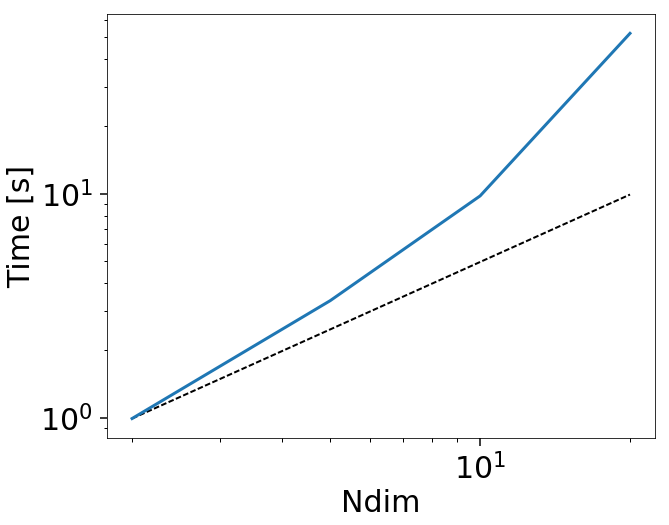

In [13]:
print("D  analytic    logz  logzerr   nlike  eff(%)   time")
for ndim, res in results.items():
    print("{:2d}   {:6.2f}  {:6.2f}     {:4.2f}  {:6d}   {:5.2f}  {:6.2f}"
          .format(ndim, analytic_logz[ndim], res.logz[-1], res.logzerr[-1],
                  sum(res.ncall)-res.nlive, res.eff, res.time))
    
figure(figsize=(10, 8))
loglog(dims, dims * results[dims[0]].time / dims[0], lw=2, color='black', ls='--')
loglog(dims, [results[ndim].time for ndim in dims], lw=3)
xlabel('Ndim')
ylabel('Time [s]')
tight_layout()

While our multi-ellipsoid rejection sampler manages to hold its own until at least 10 dimensions, it starts losing out around 20. 

## Parallelization

Although nested sampling is trivially parallelizable (in the sense that we can easily combine multiple runs together), we often would like to speed up a single run using multiple threads. Since the likelihood function is often the computational bottleneck and we often propose a number of points before updating our proposal distributions, we can use a `Pool` to "queue up" points for evaluation. This allows us to farm out the computationally intensive process of proposing new live points while keeping the serial nature of the algorithm intact.

Parallelization works better when the likelihood calls are expensive, making it computationally more expedient to try a bunch of points rather than one at a time. We'll put this in by hand here.

In [14]:
# log-likelihood function
def loglike(theta, c1, c2):
    time.sleep(1e-3)
    return logaddexp(logcirc(theta, c1), logcirc(theta, c2))

In [15]:
# parallelize ndim Gaussian shells
def parallel_run(ndim, nthreads, pool):
    """Convenience function for running in any dimension with multiple threads."""

    c1 = zeros(ndim)
    c1[0] = -3.5
    c2 = zeros(ndim)
    c2[0] = 3.5
    f = lambda theta: loglike(theta, c1, c2)
    
    sys.stdout.write("Nthreads={0}...".format(nthreads))
    sys.stdout.flush()
    sampler = dynesty.NestedSampler(f, prior_transform, ndim, bound='multi', sample='uniform', nlive=nlive,
                                    queue_size=nthreads, pool=pool, **{'bootstrap': 0})
    sampler.run_nested()
    sys.stderr.flush()
    return sampler.results

In [16]:
threads = array([1, 2, 4])
ndim = 5
npoints = 1000

# compute results
results = OrderedDict()
for nthreads in threads:
    t0 = time.time()
    with concurrent.futures.ThreadPoolExecutor(nthreads) as pool:
        results[nthreads] = parallel_run(ndim, nthreads, pool)
    results[nthreads].time = time.time() - t0
sys.stdout.write("\n")

Nthreads=1...

iter: 6151+1000 | nc: 1 | ncall: 15532 | logz: -5.647 +/-  0.081


Nthreads=2...

iter: 6123+1000 | nc: 1 | ncall: 15582 | logz: -5.684 +/-  0.081


Nthreads=4...

iter: 6129+1000 | nc: 1 | ncall: 15233 | logz: -5.708 +/-  0.081


Let's now see how we're doing.

 D  N  analytic    logz  logzerr   nlike  eff(%)   time
 5   1    -5.67   -5.65     0.08   13532   45.45   19.29
 5   2    -5.67   -5.68     0.08   13582   45.07   10.93
 5   4    -5.67   -5.71     0.08   13233   46.31    8.22


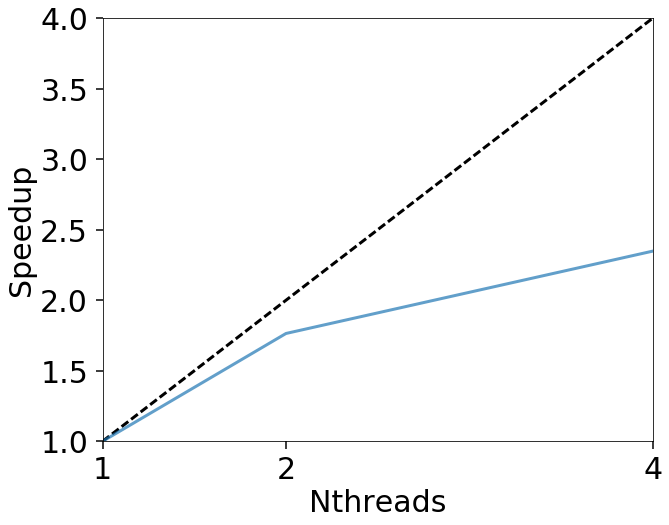

In [17]:
print(" D  N  analytic    logz  logzerr   nlike  eff(%)   time")
for nthreads, res in results.items():
    print("{:2d}  {:2d}   {:6.2f}  {:6.2f}     {:4.2f}  {:6d}   {:5.2f}  {:6.2f}"
          .format(ndim, nthreads, analytic_logz[ndim], res.logz[-1], res.logzerr[-1],
                  sum(res.ncall)-res.nlive, res.eff, res.time))
    
times = array([res.time for nthreads, res in results.items()])
speedup = times[0] / times

figure(figsize=(10,8))
plot([1, max(threads)], [1, max(threads)], color='black', ls='--', lw=3)
plot(threads, speedup, lw=3, alpha=0.7)
xlim([1, max(threads)])
ylim([1, max(threads)])
xlabel('Nthreads')
xticks(threads)
ylabel('Speedup')
tight_layout()

## Deriving Uncertainties from a Single Run

The particular statistical properties of nested sampling allow us to derive meaningful uncertainty estimates on our resulting evidence (and posteriors) using a single run. We'll go into some of the details of this below.

### Statistical Uncertainties

Nested sampling works in theory thanks to the magic of **order statistics**. At the start of our run, we sample $K$ points from the prior with likelihoods $\lbrace \mathcal{L}_1,\dots,\mathcal{L}_{K} \rbrace$ and associated prior volumes $ \lbrace X_1,\dots,X_K \rbrace$. We then want to pick the point with the maximum likelihood $\mathcal{L}_{(K)}$ out of the ordered set $\lbrace \mathcal{L}_{(1)},\dots,\mathcal{L}_{(K)} \rbrace$ with corresponding prior volume $X_{(K)}$ out of the ordered set $\lbrace X_{(1)},\dots,X_{(K)} \rbrace$. 

What is this prior volume? Well, all the points were drawn from the prior, so by the **probability integral transform (PIT)** the corresponding prior volumes are uniformly distributed **random variables** such that

$$ X_1,\dots,X_K \stackrel{i.i.d.}{\sim} \textrm{Unif} $$

where $\textrm{Unif}$ is the standard uniform distribution. It can be shown that the set of *ordered* uniformly distributed random variables (here our prior volumes) can be *jointly* represented by $K+1$ exponential random variables

$$ X_{(j)} \sim \frac{Y_1 + \cdots + Y_j}{Y_1 + \cdots + Y_{K+1}} \quad , \quad Y_1,\dots,Y_{K+1} \stackrel{i.i.d.}{\sim} \textrm{Expo} $$

where $\textrm{Expo}$ is the standard Exponential distribution.

We are interested in the marginal distribution of $X_{(K)}$ associated with $\mathcal{L}_{(K)}$, since that's the prior volume we are first sampling within. This turns out to be

$$ X_{(j=K)} \sim \textrm{Beta}(j,K-j+1) = \textrm{Beta}(K,1) $$

where $\textrm{Beta}(\alpha,\beta)$ is the Beta distribution.

Once we replace a live point with a new live point that satisfies this constraint, we now want to do the same procedure again. Using the same logic as above, we know that our prior volumes must be i.i.d. uniformly distributed *within the previous volume* (since we just replace the worst point with a new independent draw). At a given iteration $i$ where we just replaced point $i-1$ with prior volume $X_{i-1}$, the prior volume associated with a new $X_i$ we're now trying to remove is then

$$ X_i \sim t_i X_{i-1} ~,~ t_i \sim \textrm{Beta}(K,1) \quad \Rightarrow \quad X_i \sim \prod_{j=1}^{i} t_j ~,~ t_1,\dots,t_i \stackrel{i.i.d.}{\sim} \textrm{Beta}(K,1) \quad \Rightarrow \quad \ln X_i = \sum_{j=1}^{i} \ln t_i \quad . $$

Once the algorithm terminantes after $N$ iterations using some stopping criteria, we are then left with a set of $K$ live points and a final set of $\lbrace X_{N+1}=X_{(1)}, \dots, X_{N+K}=X_{(K)} \rbrace$ prior volumes. Going back to our earlier results from order statistics, we can jointly represent the ratio of their volumes with respect to $X_N$ as

$$ \frac{X_{N+j}}{X_N} \sim \frac{Y_1 + \cdots + Y_{K-j+1}}{Y_1 + \dots + Y_{K+1}} \quad . $$

Since we're probing many points during a nested sampling run, we can roughly approximate the evidence distribution using the first two (geometric) moments 

$$ E[\ln X_i] = \sum_{j=1}^{i} E[\ln t_i] = \sum_{j=1}^{i} -1/K = -i/K \quad , \quad \textrm{Var}[\ln X_i] = \sum_{j=1}^{i} \textrm{Var}[\ln t_i] = \sum_{j=1}^{i} 1/K = i/K $$

giving us 

$$ \ln X_i \approx \left. - \left(i \pm \sqrt{i}\right) \middle/ K \right. \quad , $$

which are the uncertainties generally reported by `dynesty`.

### Sampling Uncertainties

In addition to the statistical uncertainties associated with the unknown prior volumes, nested sampling is also subject to sampling uncertainties due to the particular path taken through the prior by a particular live point. In other words, although the volume $X_i$ at a given iteration $i$ can be known, the particular position $\boldsymbol{\Theta}_i$ on the iso-likelihood contour is randomly distributed. This adds some additional noise to our posterior estimates. This can also add noise to our evidence if there are problems with our particular proposal distribution that violate our assumptions above (e.g., our expected prior volume shrinkage is not the actual shrinkage).

We can probe these uncertainties by applying the "trivially parallelizable" nature of nested sampling in reverse. In particular, the particular path a particular live point $i$ takes through the prior is fully independent of the paths of all the other live points. This means we can decompose our run with $K$ live points into $K$ runs with one live point. We can then derive sampling uncertainties by bootstrap resampling these $K$ **"strands"**, re-combining them into one run, and seeing how much our evidence varies.

### Tests

Let's see how well our first and second-moment approximations are. `dynesty` has functions that allow us to simulate our statistical uncertainties (via `utils.simulate_run`), statistical uncertainties (via `utils.resample_run`), and both uncertainties jointly (via `utils.sample_run`). First let's check out the evidence.

In [18]:
# log-likelihood function
def loglike(theta, c1, c2):
    return logaddexp(logcirc(theta, c1), logcirc(theta, c2))

# parameters
r = 2. # radius of the shells
w = 0.1 # widths of the shells
const = log(1. / sqrt(2. * pi * w**2)) # normalizing constant
c1 = np.array([-3.5, 0.]) # location of shell 1
c2 = np.array([3.5, 0.]) # location of shell 2

# run sampler
f = lambda theta: loglike(theta, c1, c2)
sampler = dynesty.NestedSampler(f, prior_transform, ndim=2, bound='multi', sample='uniform', nlive=1000)
sampler.run_nested()
sys.stderr.flush()
res = sampler.results
print res.summary()

iter: 2319+1000 | nc: 1 | ncall: 6686 | logz: -1.877 +/-  0.052


nlive: 1000
niter: 2318
ncall: 5686
eff(%): 49.466
logz: -1.877 +/-  0.052


In [19]:
Nmc = 250
print 'Original:  {0} +/- {1}'.format(res.logz[-1], res.logzerr[-1])
logz_sim = array([dynesty.utils.simulate_run(res).logz[-1] for i in xrange(Nmc)])
print 'Simulated: {0} +/- {1}'.format(mean(logz_sim), std(logz_sim))
logz_resamp = array([dynesty.utils.resample_run(res).logz[-1] for i in xrange(Nmc)])
print 'Resampled: {0} +/- {1}'.format(mean(logz_resamp), std(logz_resamp))
logz_samp = array([dynesty.utils.sample_run(res).logz[-1] for i in xrange(Nmc)])
print 'Both:      {0} +/- {1}'.format(mean(logz_samp), std(logz_samp))

Original:  -1.87661474406 +/- 0.0522103456506
Simulated: -1.88287377164 +/- 0.0558622269231
Resampled: -1.88004096023 +/- 0.0548689753326
Both:      -1.87767434772 +/- 0.0828355192493


How about our posteriors? Let's see what those moments look like.

In [20]:
post_sim = empty((Nmc, 2))
post_resamp = empty((Nmc, 2))
post_samp = empty((Nmc, 2))

for i in xrange(Nmc):
    r = dynesty.utils.simulate_run(res)
    post_sim[i] = average(r.samples, weights=exp(r.logwt), axis=0)
    r = dynesty.utils.resample_run(res)
    post_resamp[i] = average(r.samples, weights=exp(r.logwt), axis=0)
    r = dynesty.utils.sample_run(res)
    post_samp[i] = average(r.samples, weights=exp(r.logwt), axis=0)

pmean, pcov = dynesty.utils.mean_and_cov(res.samples, exp(res.logwt))
    
print 'Posterior moments: {0} +/- {1}'.format(pmean, diag(pcov))
print 'Simulated [means]: {0} +/- {1}'.format(mean(post_sim, axis=0), std(post_sim, axis=0))
print 'Resampled [means]: {0} +/- {1}'.format(mean(post_resamp, axis=0), std(post_resamp, axis=0))
print 'Both [means]:      {0} +/- {1}'.format(mean(post_samp, axis=0), std(post_samp, axis=0))

Posterior moments: [-0.06201472 -0.04132775] +/- [ 14.64568874   2.10375434]
Simulated [means]: [-0.07171438 -0.0399478 ] +/- [ 0.11325929  0.04342986]
Resampled [means]: [-0.07342266 -0.04431458] +/- [ 0.15688238  0.06341272]
Both [means]:      [-0.06512183 -0.04875163] +/- [ 0.20789585  0.0778323 ]


We see a larger increase in our posterior errors from resampling then we do from our simulated weights, although compared to the actual posterior this amount of error only amounts to an additional smoothing of ~1-2%.